<a href="https://colab.research.google.com/github/Veraduks/tucker_parafac_leNet/blob/master/MNIST_LeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tensorly

In [0]:
import keras
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn import datasets
import numpy as np
import tensorly as tl
from tensorly.decomposition import parafac
from tensorly.decomposition import tucker
import matplotlib.pyplot as plt

In [0]:
from sklearn.datasets import fetch_openml
dataset = fetch_openml('mnist_784')

In [0]:
# Reshape the data to a (70000, 28, 28) tensor
data = dataset.data.reshape((dataset.data.shape[0], 28, 28))

In [0]:
# Reshape the data to a (70000, 28, 28, 1) tensord
data = data[:, :, :, np.newaxis]

In [0]:
# Scale values from range of [0-255] to [0-1]
scaled_data = data / 255.0

In [0]:
# Split the dataset into training and test sets
(train_data, test_data, train_labels, test_labels) = train_test_split(
    scaled_data,
    dataset.target.astype("int"), 
    test_size = 0.33)


In [0]:
# Tranform training labels to one-hot encoding
train_labels = np_utils.to_categorical(train_labels, 10)

In [0]:
# Tranform test labels to one-hot encoding
test_labels = np_utils.to_categorical(test_labels, 10)

In [0]:
# Create a sequential model
model = Sequential()

# Add the first convolution layer
model.add(Convolution2D(
    filters = 20,
    kernel_size = (5, 5),
    padding = "same",
    input_shape = (28, 28, 1)))

# Add a ReLU activation function
model.add(Activation(
    activation = "relu"))

# Add a pooling layer
model.add(MaxPooling2D(
    pool_size = (2, 2),
    strides =  (2, 2)))

# Add the second convolution layer
model.add(Convolution2D(
    filters = 50,
    kernel_size = (5, 5),
    padding = "same"))

# Add a ReLU activation function
model.add(Activation(
    activation = "relu"))

# Add a second pooling layer
model.add(MaxPooling2D(
    pool_size = (2, 2),
    strides = (2, 2)))

# Flatten the network
model.add(Flatten())

# Add a fully-connected hidden layer
model.add(Dense(500))

# Add a ReLU activation function
model.add(Activation(
    activation = "relu"))

# Add a fully-connected output layer
model.add(Dense(10))

# Add a softmax activation function
model.add(Activation("softmax"))

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 20)        520       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 20)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 50)        25050     
_________________________________________________________________
activation_2 (Activation)    (None, 14, 14, 50)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 50)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2450)             

In [12]:
# Compile the network
model.compile(
    loss = "categorical_crossentropy", 
    optimizer = SGD(lr = 0.01),
    metrics = ["accuracy"])
#print('\n layer_1 веса до обучения :\n', model.layers[0].weights[0])
print(model.layers[0].weights[0].shape)
print(model.layers[3].weights[0].shape)

(5, 5, 1, 20)
(5, 5, 20, 50)


In [13]:
epochs = 20

# Train the model 
history = model.fit(
    train_data, 
    train_labels, 
    batch_size = 128, 
    epochs = epochs,
	  verbose = 1)


Epoch 1/20
46900/46900 [==============================] - 8s 169us/step - loss: 1.2881 - accuracy: 0.6513
Epoch 2/20
46900/46900 [==============================] - 2s 37us/step - loss: 0.2955 - accuracy: 0.9134
Epoch 3/20
46900/46900 [==============================] - 2s 37us/step - loss: 0.2078 - accuracy: 0.9385
Epoch 4/20
46900/46900 [==============================] - 2s 38us/step - loss: 0.1635 - accuracy: 0.9513
Epoch 5/20
46900/46900 [==============================] - 2s 37us/step - loss: 0.1371 - accuracy: 0.9596
Epoch 6/20
46900/46900 [==============================] - 2s 38us/step - loss: 0.1171 - accuracy: 0.9651
Epoch 7/20
46900/46900 [==============================] - 2s 37us/step - loss: 0.1033 - accuracy: 0.9692
Epoch 8/20
46900/46900 [==============================] - 2s 37us/step - loss: 0.0927 - accuracy: 0.9725
Epoch 9/20
46900/46900 [==============================] - 2s 37us/step - loss: 0.0847 - accuracy: 0.9749
Epoch 10/20
46900/46900 [=============================

In [14]:
# Evaluate the model
(loss, accuracy) = model.evaluate(
    test_data, 
    test_labels,
    batch_size = 128, 
    verbose = 1)

23100/23100 [==============================] - 1s 22us/step


In [15]:
# Print the model's accuracy
print(accuracy)
print(loss)

0.9817748665809631
0.05933596299324201


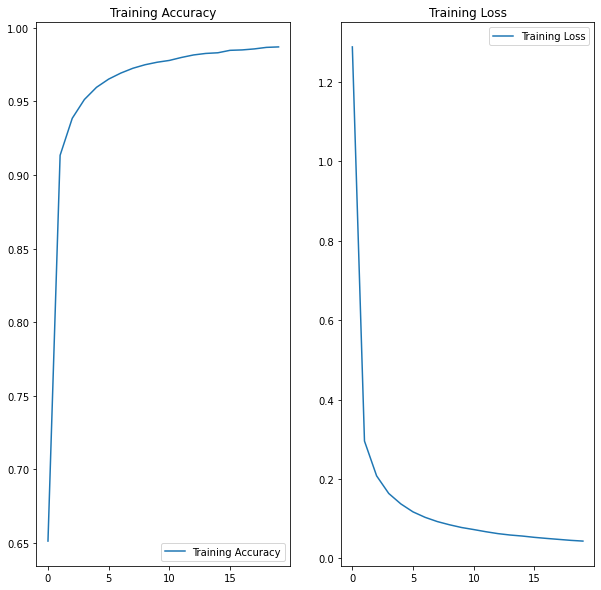

In [18]:
acc = history.history['accuracy']

loss = history.history['loss']

epochs_range = range(epochs)

plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

In [0]:
def decomposition(layer, ranks):
  '''takes a convolutional layer, prepare tucker decomposition on its weights
  and return a tucker_to_tensor object with biases'''
  old_weights = layer.weights[0].numpy()
  biases = layer.weights[1].numpy()
  core, factors = tucker(old_weights, ranks = ranks)
  new_weights = tl.tucker_to_tensor((core, factors))
  print('Well done Tucker decomposition, residual is: \n', tl.norm(new_weights-old_weights))
  return [new_weights, biases]

In [0]:
def parafac_decomposition(layer, rank):
  '''takes a convolutional layer, prepare PARAFAC decomposition on its weights
  and return a tucker_to_tensor object with biases'''
  old_weights = layer.weights[0].numpy()
  biases = layer.weights[1].numpy()
  core, factors = parafac(old_weights, rank, init = 'svd')
  new_weights = tl.kruskal_to_tensor((core, factors))
  print('Well done parafac decomposition, residual is: \n', tl.norm(new_weights-old_weights))
  return [new_weights, biases]

In [21]:
import copy
model_tucker = copy.deepcopy(model)
model_parafac = copy.deepcopy(model)

'''experiment 1'''
model_tucker.layers[0].set_weights(
    decomposition(model.layers[0], ranks = (3, 3, 1, 10)))
model_tucker.layers[3].set_weights(
    decomposition(model.layers[3], ranks = (3, 3, 10, 25)))
(loss_t, accuracy_t) = model_tucker.evaluate(
    test_data, 
    test_labels,
    batch_size = 128, 
    verbose = 1)
print('Evaluation done!')
print('Accuracy and loss with Tucker Decomposition : \n', accuracy_t, loss_t)
print('Difference in accuracy : \n', accuracy-accuracy_t)
print('\n')

'''experiment 2'''
model_parafac.layers[0].set_weights(
    parafac_decomposition(model.layers[0], rank = 1))
model_parafac.layers[3].set_weights(
    parafac_decomposition(model.layers[3], rank = 6))
(loss_p, accuracy_p) = model_parafac.evaluate(
    test_data, 
    test_labels,
    batch_size = 128, 
    verbose = 1)
print('Evaluation done!')
print('Accuracy and loss with Parafac Decomposition : \n', accuracy_p, loss_p)
print('Difference in accuracy : \n', accuracy-accuracy_p)

Well done Tucker decomposition, residual is: 
 1.1018258
Well done Tucker decomposition, residual is: 
 5.033047
23100/23100 [==============================] - 1s 22us/step
Evaluation done!
Accuracy and loss with Tucker Decomposition : 
 0.9768398404121399 0.07601788066359826
Difference in accuracy : 
 0.004935026168823242


Well done parafac decomposition, residual is: 
 2.2024703
Well done parafac decomposition, residual is: 
 5.543443
23100/23100 [==============================] - 1s 25us/step
Evaluation done!
Accuracy and loss with Parafac Decomposition : 
 0.9162770509719849 0.2833497480990051
Difference in accuracy : 
 0.06549781560897827


In [22]:
model_tucker = copy.deepcopy(model)
model_parafac = copy.deepcopy(model)

'''experiment 3'''
model_tucker.layers[0].set_weights(
    decomposition(model.layers[0], ranks = (5, 5, 1, 20)))
model_tucker.layers[3].set_weights(
    decomposition(model.layers[3], ranks = (5, 5, 20, 50)))
(loss_t, accuracy_t) = model_tucker.evaluate(
    test_data, 
    test_labels,
    batch_size = 128, 
    verbose = 1)
print('Evaluation done!')
print('Accuracy and loss with Tucker Decomposition : \n', accuracy_t, loss_t)
print('Difference in accuracy : \n', accuracy-accuracy_t)
print('\n')

'''experiment 4'''
model_parafac.layers[0].set_weights(
    parafac_decomposition(model.layers[0], rank = 20))
model_parafac.layers[3].set_weights(
    parafac_decomposition(model.layers[3], rank = 500))
(loss_p, accuracy_p) = model_parafac.evaluate(
    test_data, 
    test_labels,
    batch_size = 128, 
    verbose = 1)
print('Evaluation done!')
print('Accuracy and loss with Parafac Decomposition : \n', accuracy_p, loss_p)
print('Difference in accuracy : \n', accuracy-accuracy_p)

Well done Tucker decomposition, residual is: 
 1.8238372e-06
Well done Tucker decomposition, residual is: 
 7.135518e-06
23100/23100 [==============================] - 1s 24us/step
Evaluation done!
Accuracy and loss with Tucker Decomposition : 
 0.9817748665809631 0.059335959070559705
Difference in accuracy : 
 0.0


Well done parafac decomposition, residual is: 
 0.114449754
Well done parafac decomposition, residual is: 
 0.025206916
23100/23100 [==============================] - 1s 24us/step
Evaluation done!
Accuracy and loss with Parafac Decomposition : 
 0.9819480776786804 0.059313596872798295
Difference in accuracy : 
 -0.00017321109771728516


In [23]:
model_tucker = copy.deepcopy(model)
model_parafac = copy.deepcopy(model)

'''experiment 5'''
model_tucker.layers[0].set_weights(
    decomposition(model.layers[0], ranks = (1, 1, 1, 5)))
model_tucker.layers[3].set_weights(
    decomposition(model.layers[3], ranks = (2, 2, 5, 15)))
(loss_t, accuracy_t) = model_tucker.evaluate(
    test_data, 
    test_labels,
    batch_size = 128, 
    verbose = 1)
print('Evaluation done!')
print('Accuracy and loss with Tucker Decomposition : \n', accuracy_t, loss_t)
print('Difference in accuracy : \n', accuracy-accuracy_t)
print('\n')

'''experiment 6'''
model_parafac.layers[0].set_weights(
    parafac_decomposition(model.layers[0], rank = 1))
model_parafac.layers[3].set_weights(
    parafac_decomposition(model.layers[3], rank = 6))
(loss_p, accuracy_p) = model_parafac.evaluate(
    test_data, 
    test_labels,
    batch_size = 128, 
    verbose = 1)
print('Evaluation done!')
print('Accuracy and loss with Parafac Decomposition : \n', accuracy_p, loss_p)
print('Difference in accuracy : \n', accuracy-accuracy_p)

Well done Tucker decomposition, residual is: 
 2.2024717
Well done Tucker decomposition, residual is: 
 5.5410523
23100/23100 [==============================] - 1s 23us/step
Evaluation done!
Accuracy and loss with Tucker Decomposition : 
 0.2853679656982422 2.8959565433072836
Difference in accuracy : 
 0.696406900882721


Well done parafac decomposition, residual is: 
 2.20247
Well done parafac decomposition, residual is: 
 5.548835
23100/23100 [==============================] - 1s 23us/step
Evaluation done!
Accuracy and loss with Parafac Decomposition : 
 0.9138960838317871 0.28558149684559214
Difference in accuracy : 
 0.06787878274917603
